In [1]:
%load_ext autoreload
%autoreload 2
import sys
# adding ./model to the system path
sys.path.insert(0, './model')
from importlib import reload

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from model.stgcn import stgcn
from model.st_graph import get_distance_adjacency
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Load and preprocess the dataset

In [3]:
dataset = np.load('../../datasets/NTU-RGB/ntu_fall.npy', allow_pickle=True).item()

In [4]:
# dict_keys(['nbodys', 'njoints', 'nframes', 'joints'])
daily_raw = dataset['daily']
fall_raw = dataset['fall']

In [5]:
# select data that has at least 60 frames and at most 85 frames

nframes = []
for data in daily_raw:
    nframes.append(data['nframes'])
nframes = np.array(nframes)
indices = np.where((nframes >= 60) & (nframes <= 85))
daily = np.array(daily_raw)[indices]

nframes = []
for data in fall_raw:
    nframes.append(data['nframes'])
nframes = np.array(nframes)
indices = np.where((nframes >= 60) & (nframes <= 85))
fall = np.array(fall_raw)[indices]

print(fall.shape)
print(daily.shape)

(516,)
(460,)


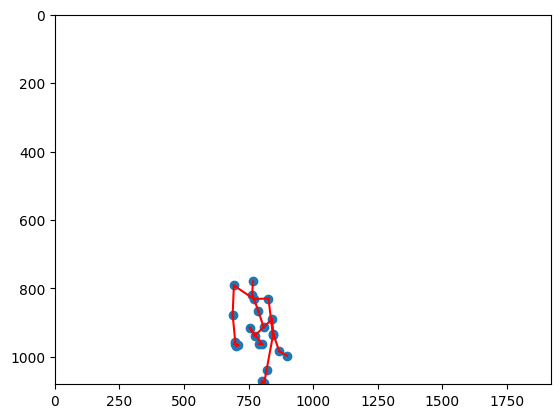

1162.957


In [6]:
count = 0
for data in fall:
    if (data['joints'][:, :, 1] >= 1080).any():
        edges = [(1, 2), (2, 21), (3, 21), (4, 3), (5, 21), (6, 5), (7, 6),
                    (8, 7), (9, 21), (10, 9), (11, 10), (12, 11), (13, 1),
                    (14, 13), (15, 14), (16, 15), (17, 1), (18, 17), (19, 18),
                    (20, 19), (22, 23), (23, 8), (24, 25), (25, 12)]

        joints = data['joints']
        frame = -1
        plt.scatter(joints[frame][:, 0], joints[frame][:, 1])
        plt.xlim(0, 1920)
        plt.ylim(0, 1080)
        for joint1, joint2 in edges:
            x_values = [joints[frame][joint1-1][0], joints[frame][joint2-1][0]]
            y_values = [joints[frame][joint1-1][1], joints[frame][joint2-1][1]]
            plt.plot(x_values, y_values, 'r-')  # 'r-' for red lines
        plt.gca().invert_yaxis()
        plt.show()
        print(np.max(data['joints'][:, :, 1]))
        break

In [7]:
# pad the data to length of 85 by repeating previous frames

fall_pad = []
daily_pad = []

for i, data in enumerate(fall):
    if np.isnan(data['joints']).any():
        continue
    
    if data['nframes'] == 85:
        fall_pad.append(data['joints'])
    else:
        num_pads = 85 - data['nframes']
        fall_pad.append(np.concatenate((data['joints'], data['joints'][:num_pads]), axis=0))

for i, data in enumerate(daily):
    if np.isnan(data['joints']).any():
        continue
    
    if data['nframes'] == 85:
        daily_pad.append(data['joints'])
    else:
        num_pads = 85 - data['nframes']
        daily_pad.append(np.concatenate((data['joints'], data['joints'][:num_pads]), axis=0))
        
fall_pad = np.array(fall_pad)
daily_pad = np.array(daily_pad)

In [8]:
# normalize the data using the max values in the dataset
# the original coordinates is stored as (x, y)

X = np.vstack((daily_pad, fall_pad)).astype(np.float32)
y = np.concatenate((np.zeros(len(daily_pad)), np.ones(len(fall_pad))))

max_x = np.max(X[:, :, :, 0])
max_y = np.max(X[:, :, :, 1])

X[:, :, :, 0] /= max_x
X[:, :, :, 1] /= max_y
X = np.transpose(X, (0, 3, 1, 2))
print(X.shape, y.shape)

(968, 2, 85, 25) (968,)


In [9]:
edges = [(1, 2), (2, 21), (3, 21), (4, 3), (5, 21), (6, 5), (7, 6),
                    (8, 7), (9, 21), (10, 9), (11, 10), (12, 11), (13, 1),
                    (14, 13), (15, 14), (16, 15), (17, 1), (18, 17), (19, 18),
                    (20, 19), (22, 23), (23, 8), (24, 25), (25, 12)]
num_node = 25

A = get_distance_adjacency(np.array(edges) - 1, num_node)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
class FallDataset(Dataset):
    def __init__(self, X, y):
        assert X.shape[0] == y.shape[0]
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# def evaluate(model, loader, print_acc=False):
#     model.eval()
#     loss_func = nn.CrossEntropyLoss()
#     acc, loss = 0.0, 0.0
#     for X_batch, y_batch in loader:
#         X_batch = X_batch.to(device)
#         y_batch = y_batch.type(torch.LongTensor).to(device)
#         with torch.no_grad():
#             batch_importance = y_batch.shape[0] / len(loader.dataset)
#             y_pred = model(X_batch)
#             batch_loss = loss_func(y_pred, y_batch)
#             batch_acc = torch.sum(torch.argmax(y_pred, axis=-1) == y_batch) / y_batch.shape[0]
#             acc += batch_acc.detach().cpu().item() * batch_importance
#             loss += batch_loss.detach().cpu().item() * batch_importance
#     if print_acc:
#         print(f"Accuracy: {acc:.3f}")
#     return loss, acc

# def evaluate(model, loader, print_acc=False):
#     model.eval()
#     loss_func = nn.CrossEntropyLoss()
#     acc, loss = 0.0, 0.0
#     all_X, all_y = [], []
    
#     # Collect all batches from the loader
#     for X_batch, y_batch in loader:
#         all_X.append(X_batch)
#         all_y.append(y_batch)
    
#     # Concatenate all batches along the batch dimension
#     all_X = torch.cat(all_X, dim=0).to(device)
#     all_y = torch.cat(all_y, dim=0).type(torch.LongTensor).to(device)
    
#     with torch.no_grad():
#         y_pred = model(all_X)
#         loss = loss_func(y_pred, all_y).item()
#         acc = (torch.sum(torch.argmax(y_pred, dim=-1) == all_y).item()) / all_y.size(0)

#     if print_acc:
#         print(f"Accuracy: {acc:.3f}")

#     return loss, acc

def evaluate(model, loader, print_acc=False):
    model.eval()
    loss_func = nn.CrossEntropyLoss()
    acc, loss = 0.0, 0.0
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.type(torch.LongTensor).to(device)
        with torch.no_grad():
            y_pred = model(X_batch)
            loss += loss_func(y_pred, y_batch).detach().cpu().item()
            acc += torch.sum(torch.argmax(y_pred, axis=-1) == y_batch).detach().cpu().item()
            
    loss /= len(loader.dataset)
    acc /= len(loader.dataset)
    return loss, acc

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=217)
training_set = FallDataset(X_train, y_train)
validation_set = FallDataset(X_valid, y_valid)

In [49]:
model = stgcn(num_class=2, window_size=85, num_point=25, graph=A)
model.to(device)

stgcn(
  (stgcn_in): Sequential(
    (0): unit_sgcn(
      (conv_nets): ModuleList(
        (0-1): 2 x Conv2d(2, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (non_linearity): ReLU()
    )
    (1): unit_tgcn(
      (conv_net): Conv2d(64, 64, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (non_linearity): ReLU()
    )
  )
  (layers): ModuleList(
    (0-2): 3 x stgcn_unit(
      (sgcn): unit_sgcn(
        (conv_nets): ModuleList(
          (0-1): 2 x Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        )
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (non_linearity): ReLU()
      )
      (tgcn): unit_tgcn(
        (conv_net): Conv2d(64, 64, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
        (bn): BatchNorm2d(64, eps=1e-05, 

Training Loss: 0.0041: 100%|██████████| 30/30 [02:02<00:00,  4.07s/it]

Training accuracy: 0.9069767441860465
Validation accuracy: 0.8762886597938144


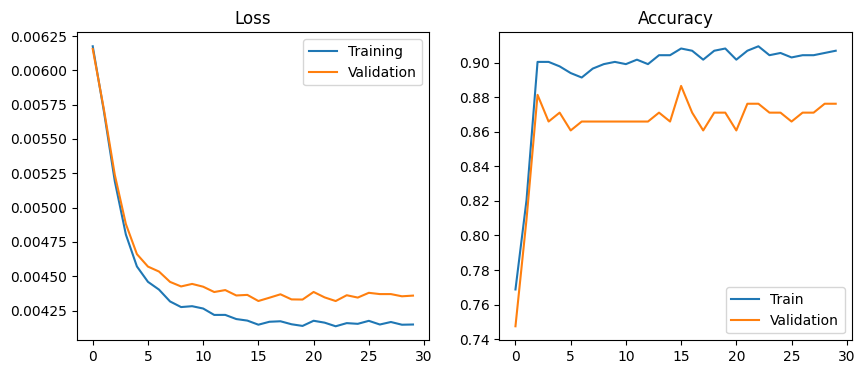

In [50]:
epochs = 30
lr = 0.01
weight_decay = 0
batch_size = 100
loss_func = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=0.1)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)

train_loss_list, train_acc_list = [], []
val_loss_list, val_acc_list = [], []

progress = tqdm(np.arange(epochs))
for n in progress:
    model.train()
    for X_batch, y_batch in training_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.type(torch.LongTensor).to(device)

        y_pred = model(X_batch)
        batch_loss = loss_func(y_pred, y_batch)

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    
    # scheduler.step()

    train_loss, train_acc = evaluate(model, training_loader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    val_loss, val_acc = evaluate(model, validation_loader)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    
    progress.set_description(f'Training Loss: {train_loss:.4f}')

x_axis = np.arange(epochs)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(x_axis, train_loss_list, label="Training")
axes[0].plot(x_axis, val_loss_list, label="Validation")
axes[0].set_title("Loss")
axes[0].legend()
axes[1].plot(x_axis, train_acc_list, label='Train')
axes[1].plot(x_axis, val_acc_list, label='Validation')
axes[1].set_title("Accuracy")
axes[1].legend()

print(f"Training accuracy: {train_acc_list[-1]}")
print(f"Validation accuracy: {val_acc_list[-1]}")

In [36]:
evaluate(model, training_loader)

(0.004065463747781069, 0.9160206718346253)

In [37]:
evaluate(model, validation_loader)

(0.004319912533170169, 0.8762886597938144)

In [38]:
torch.save(model.state_dict(), 'baseline_model_87acc.pth')